In [1]:
from google.colab import files
uploaded = files.upload()

Saving dataset_constant_padding_final.zip to dataset_constant_padding_final.zip


In [2]:
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['dataset_constant_padding_final.zip']), 'r')
data.extractall()

In [3]:
import os
from PIL import Image



---


Resize images for AlexNet

In [4]:
def resizeAndSave(file_name):
  img_size=(227,227)  
  img = Image.open(file_name) 
  img = img.resize(img_size, Image.ANTIALIAS)  
  img.save(file_name)  

In [5]:
benign_path = 'Benign/'
malignant_path = 'Malignant/'

In [9]:
#Resize images
def resizeDirectory(folder):
  folder_path = '/content/dataset_constant_padding_final/'+folder+'/' 
  folder_b = folder_path + benign_path
  folder_m = folder_path + malignant_path

  mytrainBImages = os.listdir(folder_b)
  mytrainMImages = os.listdir(folder_m)

  for cl in mytrainBImages:
    file_nameb = folder_b + cl 
    resizeAndSave(file_nameb)    

  for cl in mytrainMImages:
    file_namem = folder_m + cl 
    resizeAndSave(file_namem)



In [10]:
resizeDirectory('test')
resizeDirectory('train')
resizeDirectory('validation')

In [11]:
train_path = '/content/dataset_constant_padding_final/train'
test_path = '/content/dataset_constant_padding_final/test'
val_path = '/content/dataset_constant_padding_final/validation'



---

Common functions

In [12]:
classes = ['Benign', 'Malignant']

In [13]:
from matplotlib import pyplot
def summarize_diagnostics(history):
  # plot loss
  pyplot.figure(0)
  pyplot.title('Loss')
  pyplot.plot(history.history['loss'], color='blue', label='train')
  pyplot.plot(history.history['val_loss'], color='orange', label='test')
  pyplot.legend(['loss','val_loss']) 

  # plot accuracy
  pyplot.figure(1)
  pyplot.title('Classification Accuracy')
  pyplot.plot(history.history['accuracy'], color='blue', label='train')
  pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
  pyplot.legend(['accuracy','val_accuracy'])

In [14]:
#functions to build confusion matrix
from tqdm import tqdm
import os
import cv2
import numpy as np
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix

def load_data(dir_path):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=pyplot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    pyplot.figure(figsize = (6,6))
    pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks = np.arange(len(classes))
    pyplot.xticks(tick_marks, classes, rotation=90)
    pyplot.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')
    pyplot.show()

x_test, y_test, labels = load_data('/content/dataset_constant_padding_final/test/')
print(labels)

100%|██████████| 2/2 [00:00<00:00, 29.65it/s]

40 images loaded from /content/dataset_constant_padding_final/test/ directory.
{0: 'Benign', 1: 'Malignant'}


In [15]:
from sklearn.metrics import classification_report
def validateResults(model):   
  predictions = model.predict(x_test, batch_size=batch_size)
  y_pred = np.argmax(predictions, axis=1) 
  y_true = np.argmax(y_test, axis=0)

  print("\n"+ classification_report(y_test, y_pred, target_names=classes))
  print(confusion_matrix(y_test, y_pred))
  confusion_mtx = confusion_matrix(y_test, y_pred)
  cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)



---


AlexNet

In [16]:
import cv2
from PIL import Image
import numpy as np

In [17]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
# metric
from keras.metrics import binary_crossentropy

In [18]:
def Alexnet():
  # Initialize the model
  model = Sequential()

  # layer 1: convolutional layer + max-pooling layer
  model.add(Conv2D(filters = 96, kernel_size = (11,11), strides= 4, padding = 'valid'
  , activation='relu', input_shape = (227,227,3)))
  model.add(MaxPooling2D(pool_size = (3,3), strides = 2))

  # layer 2: convolutional layer + max-pooling layer 
  model.add(Conv2D(filters = 256, kernel_size = (5,5), padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (3,3), strides = 2))

  # layers 3-5: three convolutional layers + 1 max-pooling layer
  model.add(Conv2D(filters = 384, kernel_size = (3,3), padding = 'same', activation = 'relu'))
  model.add(Conv2D(filters = 384, kernel_size = (3,3), padding = 'same', activation = 'relu'))
  model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (3,3), strides = 2))

  # layers 6 - 8: two fully connected hidden layers and one fully connected output layer
  model.add(Flatten())
  model.add(Dense(4096, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4096, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(2, activation = 'softmax'))  

  return model

In [19]:
Alexnet_model = Alexnet()
Alexnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 384)       1

In [20]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

In [21]:
from keras.preprocessing.image import ImageDataGenerator

EPOCHS = 50
batch_size = 128

es = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)

In [22]:
datagen = ImageDataGenerator(rotation_range = 5, width_shift_range = 0.1, 
                               height_shift_range = 0.1, horizontal_flip = True)

train_it = datagen.flow_from_directory(train_path, batch_size=batch_size, target_size=(227, 227))
validation_it = datagen.flow_from_directory(val_path, batch_size=batch_size, target_size=(227, 227))
test_it = datagen.flow_from_directory(test_path, batch_size=batch_size, target_size=(227, 227))

Found 98 images belonging to 2 classes.
Found 25 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [23]:
def fitAlexNet1():
  # compile the model with a loss funciton, a metric and and optimizqation method  
  Alexnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  # fit model
  historyAlexNet1 = Alexnet_model.fit(
      train_it, 
      steps_per_epoch=len(train_it),
      validation_data=validation_it, 
      validation_steps=len(validation_it), 
      epochs=EPOCHS, 
      verbose=1,
      callbacks=[rlrop])
  
  return historyAlexNet1

In [24]:
historyAlexNet1 = fitAlexNet1()

Epoch 1/50
1/1 [==============================] - 15s 15s/step - loss: 2.4843 - accuracy: 0.5000 - val_loss: 2102.6121 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 2/50
1/1 [==============================] - 1s 1s/step - loss: 1488.3990 - accuracy: 0.6939 - val_loss: 1.5172 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 3/50
1/1 [==============================] - 1s 1s/step - loss: 1.1877 - accuracy: 0.3673 - val_loss: 1.4557 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 4/50
1/1 [==============================] - 1s 1s/step - loss: 1.1543 - accuracy: 0.3163 - val_loss: 0.6549 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 5/50
1/1 [==============================] - 1s 1s/step - loss: 0.7159 - accuracy: 0.6633 - val_loss: 2.9921 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 6/50
1/1 [==============================] - 1s 1s/step - loss: 3.2369 - accuracy: 0.3061 - val_loss: 2.0594 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 7/50
1/1 [==============================] - 1s 1s/step - loss: 1.8304 - accuracy: 0.69

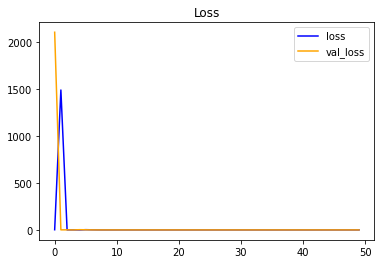

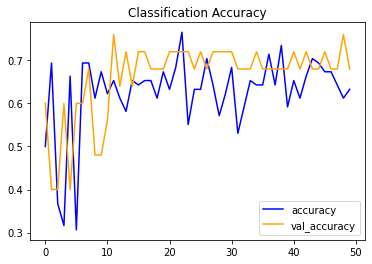

In [25]:
summarize_diagnostics(historyAlexNet1)


              precision    recall  f1-score   support

      Benign       0.76      0.73      0.75        26
   Malignant       0.53      0.57      0.55        14

    accuracy                           0.68        40
   macro avg       0.65      0.65      0.65        40
weighted avg       0.68      0.68      0.68        40

[[19  7]
 [ 6  8]]


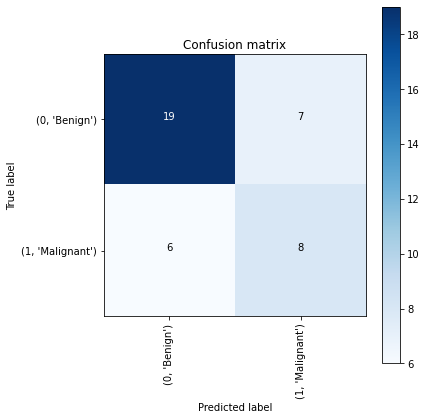

In [26]:
validateResults(Alexnet_model)

AlexNet v2

In [27]:
def fitAlexNet2():
  model = Alexnet()
  # compile the model with a loss funciton, a metric and and optimization method

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  datagen2 = ImageDataGenerator(rotation_range=15)
  
  train_it_v2 = datagen2.flow_from_directory(train_path, batch_size=batch_size, target_size=(227, 227))
  validation_it_v2 = datagen2.flow_from_directory(val_path, batch_size=batch_size, target_size=(227, 227))
  test_it_v2 = datagen2.flow_from_directory(test_path, batch_size=batch_size, target_size=(227, 227))

  # fit model
  historyAlexNet2 = model.fit(
      train_it_v2, 
      steps_per_epoch=len(train_it_v2),
      validation_data=validation_it_v2, 
      validation_steps=len(validation_it_v2), 
      epochs=EPOCHS, 
      verbose=1,
      callbacks=[rlrop])
  
  return historyAlexNet2, model

In [28]:
historyAlexNet2, alexNet2 = fitAlexNet2()

Found 98 images belonging to 2 classes.
Found 25 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 2.5414 - accuracy: 0.3878 - val_loss: 2148.9385 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 2/50
1/1 [==============================] - 1s 1s/step - loss: 1547.9844 - accuracy: 0.6939 - val_loss: 0.7752 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 3/50
1/1 [==============================] - 1s 1s/step - loss: 1.2155 - accuracy: 0.6939 - val_loss: 4.9911 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 4/50
1/1 [==============================] - 1s 1s/step - loss: 6.3444 - accuracy: 0.3061 - val_loss: 0.7953 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 5/50
1/1 [==============================] - 1s 1s/step - loss: 0.8572 - accuracy: 0.3061 - val_loss: 0.6798 - val_accuracy: 0.6400 - lr: 0.0010
Epoch 6/50
1/1 [==============================] - 1s 1s/step - loss: 0.6575 - accuracy: 0.7041 - val_loss: 0.7701 - val_accu

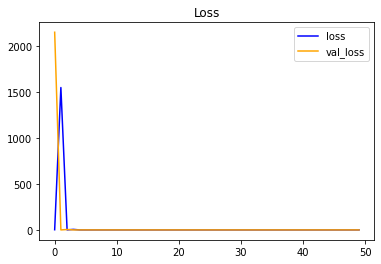

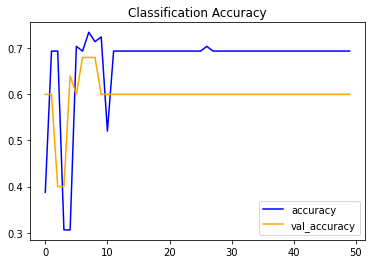

In [29]:
summarize_diagnostics(historyAlexNet2)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



              precision    recall  f1-score   support

      Benign       0.65      1.00      0.79        26
   Malignant       0.00      0.00      0.00        14

    accuracy                           0.65        40
   macro avg       0.33      0.50      0.39        40
weighted avg       0.42      0.65      0.51        40

[[26  0]
 [14  0]]


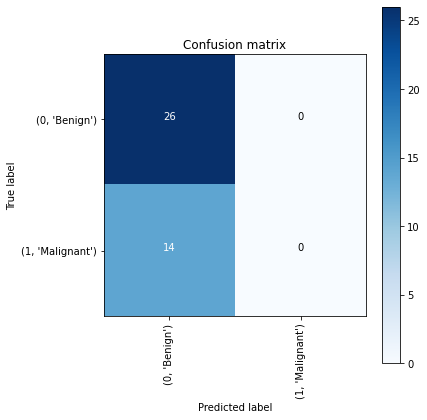

In [30]:
validateResults(alexNet2)

In [31]:
from tensorflow.keras.optimizers import RMSprop
def fitAlexNet3():
  model3 = Alexnet()
  # compile the model with a loss funciton, a metric and and optimization method

  model3.compile(optimizer=RMSprop(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

  datagen2 = ImageDataGenerator(rotation_range=15)
  
  train_it_v2 = datagen2.flow_from_directory(train_path, batch_size=batch_size, target_size=(227, 227))
  validation_it_v2 = datagen2.flow_from_directory(val_path, batch_size=batch_size, target_size=(227, 227))
  test_it_v2 = datagen2.flow_from_directory(test_path, batch_size=batch_size, target_size=(227, 227))

  # fit model
  historyAlexNet3 = model3.fit(
      train_it_v2, 
      steps_per_epoch=len(train_it_v2),
      validation_data=validation_it_v2, 
      validation_steps=len(validation_it_v2), 
      epochs=EPOCHS, 
      verbose=1,
      callbacks=[rlrop])
  
  return historyAlexNet3, model3

In [32]:
historyAlexNet3, alexNet3 = fitAlexNet3()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Found 98 images belonging to 2 classes.
Found 25 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 1.9585 - accuracy: 0.5510 - val_loss: 55.5418 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - 1s 1s/step - loss: 39.6544 - accuracy: 0.6939 - val_loss: 4.5690 - val_accuracy: 0.4000 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - 1s 1s/step - loss: 5.4909 - accuracy: 0.3061 - val_loss: 2.5132 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 4/50
1/1 [==============================] - 1s 1s/step - loss: 1.8716 - accuracy: 0.6939 - val_loss: 0.6556 - val_accuracy: 0.6400 - lr: 1.0000e-04
Epoch 5/50
1/1 [==============================] - 1s 1s/step - loss: 0.6527 - accuracy: 0.6224 - val_loss: 0.8197 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 6/50
1/1 [==============================] - 1s 1s/step - loss: 0.6364 - accuracy: 0.6939 - val_loss: 0

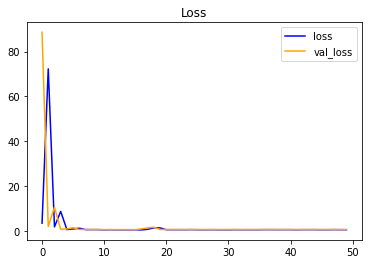

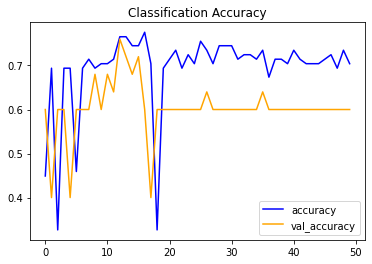

In [ ]:
summarize_diagnostics(historyAlexNet3)


              precision    recall  f1-score   support

      Benign       0.69      0.85      0.76        26
   Malignant       0.50      0.29      0.36        14

    accuracy                           0.65        40
   macro avg       0.59      0.57      0.56        40
weighted avg       0.62      0.65      0.62        40

[[22  4]
 [10  4]]


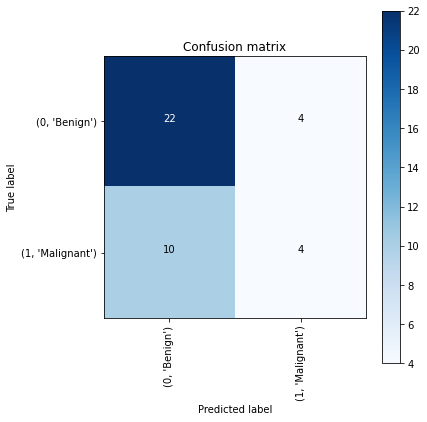

In [33]:
validateResults(alexNet3)